# Chapter 10 収束しない場合の対処法

MCMCが収束しない理由は、ほとんどの場合モデルが原因である。この章では収束しない主な原因として以下の4つの場合を挙げ、対処法を説明する。
- パラメータが識別不可能: モデル式を整理して入念に検討することで対処する[(10.1節)](#101-パラメーターの識別可能性)
- データが少ないにもかかわらずモデルが複雑すぎる、あるいはパラメータに制約がない: 弱情報事前分布で対処する[(10.2節)](#102-弱事前情報分布)
- パラメータ間の依存が強く、事後分布がいびつ: 再パラメータ化で対処する[(10.3節)](#103-再パラメータ化)
- その他: 例えば、微分が不連続な関数を使ったモデルや、局所最適が多いため事後分布を求めるのが難しいモデルの場合。モデル式の変形や発展的手法によって対処できることがある[(10.4節)](#104-その他の場合)

## 10.1 パラメータの識別可能性

### 10.1.1 識別可能とは

識別可能(identifiable)について、モデル4-3を例に説明する。

モデル式 4-3(再掲)

$$
\begin{align}
&Y[n] = a + bX[n] + cX[n] + \varepsilon[n] &n= 1, ..., N \nonumber \\
&\varepsilon[n] \sim Normal(0, \sigma) &n= 1, ..., N \nonumber
\end{align}
$$

ここで$\epsilon[n]$は、平均0・標準偏差$\sigma$の正規分布から生成されるとしているが、これをあるパラメータcを導入して、平均$cX[n]$・標準偏差$\sigma$の正規分布から生成されると考える。すると、モデル式4-3は以下のモデル式に変形できる。

モデル式 10-1

$$
\begin{align}
&Y[n] = a + bX[n] + cX[n] + \varepsilon'[n] \nonumber \\
&Y[n] = a + (b + c)X[n] + \varepsilon'[n] &n= 1, ..., N \nonumber \\
&\varepsilon'[n] \sim Normal(0, \sigma) &n= 1, ..., N \nonumber
\end{align}
$$

ここでa,b,cの事前分布は同じ無情報分布を設定し、データから推測する。

傾きが3.0だとした場合、
モデル式 4-3では$b=3.0$になればよいが、モデル式 10-1では$(b + c)=3.0$を満たす必要があり、$(b, c)$の組み合わせは無数に存在する。このため、bとcは識別不可能である。MCMCを実行しても収束しない。

書き直すと、
- あるパラメータの値$a$において、事後確率を$p(\theta = a | Y)$とする
- $p(\theta = a | Y) = p(\theta = b | Y)$となる別のパラメータ$b$が存在しない時、パラメータ$\theta$は識別可能である
- 逆に今回のように別のパラメータbが存在する場合は識別不可能

バラメータが識別不可能なときの対処法
- b, cどちらかのパラメータを削除する
- b, cの事前分布をを異なるものにする

モデル式をきちんと書いて、数式を整理する癖をつけること。

### 10.1.2 個人差

[5.1節](chap05.ipynb#51-重回帰)の重回帰では以下のモデル式を考えた。

モデル式 5-1(再掲)

$$
\begin{align}
Y &= b_1 + b_2A[n] + b_3Score[n] + \varepsilon[n] \quad &n=1, ..., N \nonumber \\
\epsilon[n] &\sim Normal(0, \sigma) \quad &n=1, ..., N \nonumber
\end{align}
$$

ここで出席率の個人差$b_{個人差}[n]$を考慮すると、以下のモデル式になる。

$$
\begin{align}
Y[n] &= b_1 + b_2A[n] + b_3Score[n] + b_{個人差}[n] + \varepsilon[n] \quad &n=1, ..., N \nonumber \\
b_{個人差}[n] &\sim \mathrm{Normal}(0, \sigma_b) \quad &n=1,..., N \nonumber \\
\epsilon[n] &\sim \mathrm{Normal}(0, \sigma) \quad &n=1, ..., N \nonumber
\end{align}
$$

$\sigma_b$と$\sigma$の事前分布が同じ無情報事前分布とすると、$b_{個人差}[n]$と$\varepsilon[n]$は添字も同じで従う分布も全く同じであり、識別不可能。データが各個人に一つずつしかないため、説明変数以外の影響を個人差とノイズに切り分けて推定できないのだ。この状況もモデル式をきちんと書いて数式を整理すれば気づくことができるだろう。

### 10.1.3 ラベルスイッチング

パラメータが識別不可能な典型例がラベルスイッチング(label switching)である。

例として、下図10.1のようにヒストグラムを描くと山が二つあるデータに対し、2つの正規分布($\mathrm{N}(\mu_1, \sigma_1), \mathrm{N}(\mu_2, \sigma_2)$)を特定の割合($a:1-a$)で混ぜた混合正規分布を考える。

この分布の式は以下となる
$$
\mathrm{Normal\_Mixture}(y|a, \mu_1, \sigma_1, \mu_2, \sigma_2) = a \times \mathrm{N}(y|\mu_1, \sigma_1) + (1 - a) \times \mathrm{N}(y|\mu_2, \sigma_2)
$$

![Alt text](chap10/output/fig10-1.png)

例えば、以下の組み合わせは結果的に同一の分布を表すので識別不可能
- $(a, \mu_1, \sigma_1, \mu_2, \sigma_2) = (0.3, 0, 2, -4, 1)$
- $(a, \mu_1, \sigma_1, \mu_2, \sigma_2) = (0.7, -4, 1, 0, 2)$

つまり分布$\mathrm{N}(\mu_1, \sigma_1)$は左の山を表してもいいし、右の山でもいい事になる。これがラベルスイッチングである。

MCMC実行時の不具合
- 一つのMCMCサンプル列を見ても、$(0.3, 0, 2，-4, 1)$の近傍と$(0.7，-4, 1, 0, 2)$の近傍の間を振動する状況となり、サンプリングがうまくいかない
- 二つの正規分布が合体して、$(\mu_1, \sigma_1)$と$(\mu_2, \sigma_2)$が同じ値になってしまう
- chainによって別々の値へ収束するため$\hat{R}$が適切に計算できない

対処法としては、Stanコードでordered型を使い、ordered[2] mu と宣言。$\mu1 \lt \mu2$ の制限を入れる。しかし一般的にラベルスイッチングを解決することは難しい場合が多い。

### 10.1.4 多項ロジスティクス

[6.5項](chap06.ipynb#65-カテゴリカル分布)で挙げた例を使う。

データファイル 10.1[data-category.txt](chap10/input/data-category.txt)

ここで
- $\mathrm{K}$: カテゴリー数 = 6
- $Age$: 購入者の年齢
- $Sex$: 購入者の性別(0＝男性、1＝女性)
- $Income$: 購入者の年収(万円)
- $Y$: 購入した商品のカテゴリーのインデックス(1～Kのいずれかの整数値)

解析の目的は、
- どのような年齢・性別・年収の人がどのカテゴリーを選びやすいかを知ること

モデル式6-2では、各カテゴリーを選ぶ確率百は説明変数である年齢・性別・年収の線形結合で決まるとし、以下のような多項ロジスティック回帰を考えた。

モデル式 10-2 (モデル式6-2の再掲)
$$
\begin{align}
&\overrightarrow{\mu[n]} = \overrightarrow{b_1} + \overrightarrow{b_2}Age[n] + \overrightarrow{b_3}Sex[n] + \overrightarrow{b_4}Income[n] & n = 1, ..., N \nonumber \\
&\overrightarrow{\theta[n]} = \mathrm{softmax } (\overrightarrow{\mu[n]}) & n = 1, ..., N \nonumber \\
&Y[n] \sim \mathrm{Categorical } (\overrightarrow{\theta[n]}) & n = 1, ..., N \nonumber
\end{align}
$$

ここで、$\overrightarrow{\mu[n]}, \overrightarrow{\theta[n]}, \overrightarrow{b_1}, \overrightarrow{b_2}, \overrightarrow{b_3}, \overrightarrow{b_4}$はそれぞれ長さKのベクトルであり、$\overrightarrow{b_1} \sim \overrightarrow{b_4}$をデータから推定する。[6.5節](chap06.ipynb#65-カテゴリカル分布)で説明したように、$(-\infty,\infty)$である説明変数の線形結合$\overrightarrow{\mu}$から、simplexである$\overrightarrow{\theta}$を作るには以下のsoftmax関数を使うと便利。

$$
\vec{\theta} = \mathrm{softmax } \left( \frac{\exp(x_1)}{\sum_{k'=1}^K \exp(x_{k'})} \cdots \frac{\exp(x_K)}{\sum_{k'=1}^K \exp(x_{k'})} \right)^T
$$

$\vec{\mu}$の各要素は、各カテゴリーを選ぶ「強さ」と見なすことができる。

ここで、すべてのカテゴリーの$\mu_k$を$\mu_k + 1$に変更してみよう。すると、
$$
\theta_{k}=\frac{\exp\left(\mu_{k}+1\right)}{\sum_{k^{\prime}=1}^{K}\exp\left(\mu_{k^{\prime}}+1\right)}=\frac{\exp\left(\mu_{k}\right)\exp\left(1\right)}{\sum_{k^{\prime}=1}^{K}\left[\exp\left(\mu_{k^{\prime}}\right)\exp\left(1\right)\right]}=\frac{\exp\left(\mu_{k}\right)}{\sum_{k^{\prime}=1}^{K}\exp\left(\mu_{k^{\prime}}\right)}
$$
となって元の形に戻る。各$\mu_k$が平行移動しても$\vec{\theta}$は変わらないのである。つまり、各$\mu_k$は一意に決まらず説別不可能である。ここでは識別できるように、カテゴリー1を選ぶ「強さ」を0に固定する。すると残りのカテゴリーを選ぶ「強さ」はカテゴリー1との比較から決まる。実装するには$\mu_{1}=0$に固定すればよい。すなわち、ベクトル$\vec{b_1}$の1番目の要素を$b_{1,1}$と書くことにすると、$b_{1,1}=b_{2,1}=b_{3,1}=b_{4,1}=0$に固定すればよい。

[モデル式10-2の実装例](chap10/model/model10-2.stan)

9～12行目: transformed dataブロックはデータをStanコードの中で作るためのブロックである。データをR側から渡すのが面倒な場合や、Stanの関数で加工したい場合などに活用するとよい。ここでは、$b_{1,1}=b_{2,1}=b_{3,1}=b_{4,1}=0$にするためのゼロベクトルを作っている。rep_vector(x、m)関数はxをm個繰り返し並べたvectorを作る関数である。

19,21行目: ゼロベクトルの列とD行K-1列の行列をappend_col関数で横に並べてD行K列の行列であるbを作っている。このように一部が固定値を持つパラメータはtransformed parametersブロックで作るとよい。

27行目: softmax関数を使ってsimplexにしている。softmax関数はvector型しか引数にとることができない。しかし、mu[m,]は行列のn行目でrow_vector型なので、転置演算子である「,」(シングルクォート)を使ってvector型にしている。

なお、Stanでは内部的にsoftmaxを実行する、安定かつ高速である便利なcategorical_logit関数が用意されているので、それを使うと27行目は以下のように書くことができる。
$$
\mathrm{Y[n]}\ \sim\ \mathrm{Categorical\_logit}\left(\mathrm{mu[n,]}' \right);
$$


### 10.1.5 ウサギとカメ

識別可能性に関する例をもう一つ挙げる。ウサギとカメのマラソンの勝敗結果からウサギとカメの「強さ」を推定する。30試合分の勝敗結果を記録した。カンマ区切りのファイルがあるとする。

[データファイル10.2: data-usagitokame.txt](chap10/input/data-usagitokame.txt)

- 1行が1試合分
- Loser: 負けたプレイヤー(敗者)のインデックス
- Winner: 勝ったプレイヤー(勝者)のインデックス
- インデックス1がカメ、2がウサギ

モデリングすると
- 試合(game)ごとに発揮できた強さをパフォーマンスとする
- パフォーマンスは正規分布に従うとする
- カメのパフォーマンス: 平均(強さ)$\mu[1]$・標準偏差(勝負ムラ)$\sigma[1]$の正規分布
- ウサギのパフォーマンス: 平均(強さ)$\mu[2]$・標準偏差(勝負ムラ)$\sigma[2]$の正規分布
- この時点では勝負ムラは$\sigma[1] = \sigma[2] = \sigma$で共通とする

尤度を考える場合に注意するポイント: パフォーマンスの差だけが勝敗に影響する単純なモデルなので、各々の強さ($\mu$)を変更しても同じ尤度になる。識別できるようにするためにまず[10.1.4項](#1014-多項ロジスティクス)と同じように片方の強さを0に固定する

- $\mu[1]=0$

パフォーマンスのスケール(大きさのオーダー)が決まっていないのでこのままではまだ識別できない。例えば$(\mu[2], \sigma) = (3, 2)$と$(\mu[2], \sigma) = (6, 4)は同じ尤度になる。そこでさらに勝負ムラを固定する。

- $\sigma = 1$

パフォーマンスは観測されないパラメータであり、大小関係がある。このような場合にはStanでorderd型を使うと便利。([9.4.3項](#943-)参照)

モデル式
$$
\begin{align}
performance[g, 1] &\sim \mathrm{Normal}\left(\mu[{Loser}[g]], 1\right) \quad &g = 1, \ldots, G \nonumber \\
performance[g, 2] &\sim \mathrm{Normal}\left(\mu[{Winner}[g]], 1\right) \quad &g = 1, \ldots, G \nonumber \\
performance[g, 1] &\lt performance[g, 2] \quad &g = 1, \ldots, G \nonumber \\
\mu[1] &= 0 \nonumber
\end{align}
$$

ここで、
- $G$: 試合数
- $g$: 試合のインデックス
- $performance[g, 1]$: 敗者のパフォーマンス
- $performance[g, 2]$: 勝者のパフォーマンス
- Loser[g], Winner [g]: 敗者/勝者のインデックス
- モデル式の３行目は変数の制約を表す

データから$\mu[2]$および$performance[g, 1]、 performance[g, 2]$を推定する。

この例のように、「データの分布の確認」と「メカニズムの想像」がつながりにくい場合には、シミュレーションが特に大切である。仮に$\mu[2]＝1.5$として、パフォーマンスを生成して勝敗の集計をとるコードは以下となる。

[元のRコード](chap10/sim-model10-3.R)

さらに生成した勝敗のデータを使用して、モデル式10-3のstanで$\mu[2]$の推定を行ってみる。

[model10-3.stan](chap10/model/model10-3.stan)

最後にデータファイル10.2を用いた推定の結果、カメの強さを0とした時のウサギの強さであるbの中央値と95%ベイズ信頼区間は1.60(0.84~2.47)となり、強さの幅まで知ることができた。


In [16]:
import polars as pl
from cmdstanpy import CmdStanModel

"""モデル式10-2の実行."""
category = pl.read_csv("./chap10/input/data-category.txt")
X = category.select(
    pl.lit(1).alias("const"),
    pl.col("Age") / 100,
    pl.col("Sex"),
    pl.col("Income") / 1000,
)

data = {
    "N": category.shape[0],
    "D": X.shape[1],  # 1(切片項)+説明変数の数。(N,D)のmatrix型作成用
    "K": category["Y"].n_unique(),
    "X": X.to_numpy(),
    "Y": category["Y"].to_list(),
}
sm = CmdStanModel(stan_file="./chap10/model/model10-2.stan")
fit = sm.sample(data=data, seed=1234)
fit.summary()

17:24:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:25:11 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-454.125000,0.080070,3.302490,-460.034000,-453.832000,-449.372000,1701.15,54.9609,1.000630
"b_raw[1,1]",-0.195715,0.027469,1.088050,-1.948450,-0.199471,1.608200,1568.93,50.6892,0.999927
"b_raw[1,2]",0.188815,0.039182,1.802670,-2.758160,0.198663,3.143070,2116.75,68.3880,1.000590
"b_raw[1,3]",-1.044070,0.028791,1.211040,-3.016280,-1.014190,0.897333,1769.37,57.1648,1.001000
"b_raw[1,4]",2.209350,0.057974,2.773310,-2.267730,2.185750,6.743440,2288.37,73.9330,1.002920
...,...,...,...,...,...,...,...,...,...
"mu[300,2]",1.285610,0.012622,0.568396,0.363606,1.279450,2.228030,2027.82,65.5149,0.999673
"mu[300,3]",-0.698246,0.018621,0.965972,-2.329110,-0.676966,0.853544,2690.95,86.9394,1.000120
"mu[300,4]",1.485700,0.012663,0.598442,0.517745,1.470820,2.503300,2233.24,72.1518,1.000700
"mu[300,5]",-5.587480,0.036804,1.990750,-9.082070,-5.447230,-2.553790,2925.84,94.5284,1.000840


In [39]:
import numpy as np
import polars as pl

"""勝敗の集計とmuの推定."""
rand_gen = np.random.default_rng(seed=123)

G = 30
mu_pf = (0, 1.5)
pf = rand_gen.normal(loc=mu_pf, scale=1, size=(G, 2))
d = pl.DataFrame(np.argsort(pf, axis=1) + 1, schema=("Loser", "Winner"))
tbl = d.pivot(  # noqa: PD010
    "Winner",
    "Loser",
    "Winner",
    aggregate_function="count",
    sort_columns=True,
).fill_null(0)
print(tbl)  # noqa: T201

data = {
    "N": d.shape[1],
    "G": d.shape[0],
    "LW": d.to_numpy(),
}
sm = CmdStanModel(stan_file="./chap10/model/model10-3.stan")
fit = sm.sample(data=data, seed=1234)
fit.summary(percentiles=[2, 50, 97])

18:08:20 - cmdstanpy - INFO - CmdStan start processing


shape: (2, 3)
┌───────┬─────┬─────┐
│ Loser ┆ 1   ┆ 2   │
│ ---   ┆ --- ┆ --- │
│ i64   ┆ u32 ┆ u32 │
╞═══════╪═════╪═════╡
│ 1     ┆ 0   ┆ 23  │
│ 2     ┆ 7   ┆ 0   │
└───────┴─────┴─────┘


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:08:21 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,2%,50%,97%,N_Eff,N_Eff/s,R_hat
lp__,-31.408100,0.183970,6.127630,-45.115800,-31.161400,-20.83210,1109.400000,826.062000,1.003080
"performance[1,1]",-0.279039,0.012420,0.901818,-2.234450,-0.244403,1.39338,5271.990000,3925.530000,0.999589
"performance[1,2]",1.333460,0.014661,0.920861,-0.525269,1.305030,3.09461,3944.840000,2937.330000,0.999893
"performance[2,1]",-0.301520,0.011924,0.890385,-2.136480,-0.281830,1.33052,5576.020000,4151.910000,0.999626
"performance[2,2]",1.349170,0.014962,0.918483,-0.462399,1.317810,3.11505,3768.270000,2805.860000,1.001550
...,...,...,...,...,...,...,...,...,...
"performance[30,1]",-0.286501,0.012021,0.893767,-2.172130,-0.251584,1.33504,5527.950000,4116.120000,0.999575
"performance[30,2]",1.340800,0.014488,0.914551,-0.437788,1.311420,3.13196,3984.570000,2966.920000,0.999909
b,1.041629,0.007195,0.356182,0.326264,1.037610,1.73846,2450.748608,1824.831428,1.001969
mu[1],0.000000,NaN,0.000000,0.000000,0.000000,0.00000,NaN,NaN,NaN


In [40]:
import polars as pl
from cmdstanpy import CmdStanModel

"""データファイル10.2を用いた。パラメータの推定."""
usagitokame = pl.read_csv("./chap10/input/data-usagitokame.txt")
data = {
    "N": usagitokame.shape[1],
    "G": usagitokame.shape[0],
    "LW": usagitokame.to_numpy(),
}
sm = CmdStanModel(stan_file="./chap10/model/model10-3.stan")
fit = sm.sample(data=data, seed=1234)
fit.summary(percentiles=[2, 50, 97])

18:08:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:08:42 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,2%,50%,97%,N_Eff,N_Eff/s,R_hat
lp__,-23.732700,0.193295,6.506140,-38.154100,-23.516500,-12.34750,1132.940000,870.820000,1.004180
"performance[1,1]",-0.149877,0.013167,0.919167,-2.039060,-0.124059,1.50861,4873.030000,3745.600000,0.999661
"performance[1,2]",1.761610,0.017241,1.012550,-0.208184,1.712290,3.74261,3449.160000,2651.160000,1.000470
"performance[2,1]",-0.178659,0.013728,0.940936,-2.164030,-0.168229,1.52617,4697.580000,3610.750000,0.999965
"performance[2,2]",1.796390,0.017336,0.997137,-0.129637,1.767820,3.74008,3308.330000,2542.910000,1.000450
...,...,...,...,...,...,...,...,...,...
"performance[30,1]",-0.190789,0.012622,0.921185,-2.169940,-0.153437,1.50050,5326.830000,4094.410000,0.999488
"performance[30,2]",1.762770,0.016893,0.994284,-0.176920,1.719660,3.70966,3464.110000,2662.650000,0.999506
b,1.602507,0.009037,0.420424,0.770170,1.600410,2.42637,2164.203888,1663.492612,1.000625
mu[1],0.000000,NaN,0.000000,0.000000,0.000000,0.00000,NaN,NaN,NaN


## 10.2 弱情報事前分布

- 複雑なモデルに対してデータが少なく収束しない場合: シンプルなモデルから徐々にに構築していくことで、どの仮定に無理があったか調べる。
- 複雑なモデルを使わざるを得ない場合や、パラメータの制約が全くないため収束しにくかったり常識や経験からは考えにくい推定値になる場合: 無情報事前分布の代わりに弱情報事前分布(weakly informative prior)を使う。ただしはじめは無情報事前分布を使い問題があれば少しずつ弱情報事前分布に変えてみて、頑健性があるか確認する。

### 10.2.1 $(-\infty, \infty)$の範囲のパラメータ

一般的に$(-\infty, \infty)$の範囲のパラメータには${\mathrm{Normal}}(0,100)$のような平らな無情報事前分布を使うが、背景知識から弱情報事前分布を使う場合がある。

- パラメータの値が特定の範囲$[a, b]$である可能性が高い場合
  弱情報事前分布$\mathrm{Uniform}(a, b)$という一様分布を使うと考えるかもしれないが注意が必要。推定されたMCMCサンプルが境界(a, b)付近に存在し、事後分布の密度関数が境界で切断されたようになっているなら、境界の指定の仕方によって推定結果が大きく異なるので頑健性がない。一様分布を使うとこのような懸念点がある。
  Stan開発チームは$\mathrm{Uniform}(a, b)$の代わりに、境界のない平均$(a+b)/2$・標準偏差$(b-a)/2$の正規分布を使うことを推奨している。この正規分布を$[a, b]$の範囲で積分すると範囲内の確率は0.67、範囲外は0.33の可能性が残っているとも解釈できる。

- 回帰係数
  絶対値の大きい回帰係数は「あり得ない」または「過学習の恐れがある」と考えられる場合がしばしばある。この場合には、回帰係数の事前分布に弱情報事前分布を設定して、絶対値の大きい推定値にペナルティを課すとよい。特にロジスティック回帰で使われることが多い。弱情報事前分布としては、Stan開発チームはStudentの分布$(\mathrm{Student\text{-}t} (\nu=\nu_{0},\mu=0,\sigma=\sigma_{0} ))$を推奨している。ここで、自由度$\nu$は$[3, 7]$の範囲の固定値$\nu_0$である。スケール$\sigma$は「回帰係数の絶対値は高々$\sigma_0$程度だろう」という背景知識から固定値$\sigma_0$に決める。すると、例えば自由度4の場合には、$\mathrm{Student\_t}(4,0,\sigma_{0})$を$[-\sigma_{0},\sigma_{0}]$の範囲で積分して求めた確率は0.63になるので、$[-\sigma_{0},\sigma_{0}]$の範囲外にも0.37の可能性を残しているとも解釈できる。
  さらに情報を強めたい場合は、平均$0$・標準偏差$\sigma_0$の正規分布を使う。これは機械学習の枠組みでは係数の2乗の和をペナルティとしたridge回帰に相当する。これは回帰係数bをvector型とすると、「b ~ normal(0, 10)」と「対数事後確率lp__に$-0.5\times\sum(b_{k}/10)^2$を加えること」が同じだからである([4.3節参照](chap04.ipynb#43))。

  ### 10.2.2 正の値を持つパラメータ

正の値を持つパラメータの事前分布には$\mathrm{Uriform}(0,\,1000)$のような十分に幅が広い一様分布(無情報事前分布)を使うのが第一選択肢であるが、データが少ない場合などは、そのパラメータの事後分布が、背景知識から外れて大きな値へ長く尾を引いてしまうことがある。この要な場合には弱情報事前分布を使う。
- 標準偏差
  過去には分散のパラメータ対し逆ガンマ分布(共役事前分布)が紙と鉛筆で計算できるため使われていたが、頑健性が下がるケースが有る(個人間の分散が0に近い場合)。
  なぜなら、逆ガンマ分布は原点を必ず通るので、例えばこの分布使った二つの事前分布${\mathrm{invGamma~(0.1,~0.1)~}}\geq{\mathrm{~invGamma~(0.001,~0.001)}}$を比較すると、0の近くで大きく確率密度が異なり、事後分布も0の近くで大きく形が変わってしまうため(図10.2)。つまり分布のハイパーパラメータの選び方で結果が大きく変わる。対数正規分布の場合も同様。
  \
  対策: 分散ではなく標準偏差のパラメータの弱情報事前分布として、半t分布$(\mathrm{Stuadent\_t^+}(\nu = \nu_0, \; \mu = 0, \; \sigma=\sigma_0))$を設定(図10.3)
  - 0の近くにも確率密度が十分ある
  - 自由度$\nu$は3か4の固定値を使うことが多い
  - スケール$\sigma=\sigma_0$(「標準偏差のパラメータは高々$\sigma_0$程度」という背景知識)
  - さらに情報を強めたい場合: 半正規分布$(\mathrm{Normal^+}(0,\sigma_0))$を使うとよい
  
  なお、これらの正の値に制限された半分布をStanで表現するには、parametersブロックで<lower=0>を指定するだけでよい([9.4.4項参照](chap09.ipynb#944))。
  \
  階層モデルの例: [model8-4.stan](chap08/model/model8-4.stan)での「新卒の基本年収」の会社差のバラツキ(s_a)のMCMCサンプルのヒストグラム(図10.4(左))は大きな値へ尾を引いている。ここに会社差のばらつきは高々100万円だろいうという背景知識を追加する。
  $$
  \sigma_a \sim \mathrm{Stuadent\_t^+}(4, 0, 100)
  $$
  このとき$\sigma_a$(s_a)のMCMCサンプルのヒストグラムは図10.4(右)となる。
  - stanモデルのmodel欄に以下を追加を[model8-4b.stan](chap10/model/model8-4b.stan)
    ```s_a ~ student_t(4, 0, 100);```
  - 尾が抑えられている
  - 中央値と95%ベイズ信頼区間が変化
  
  この推定が頑健か確認するために半t分布をいろいろ変更して推定するとよい

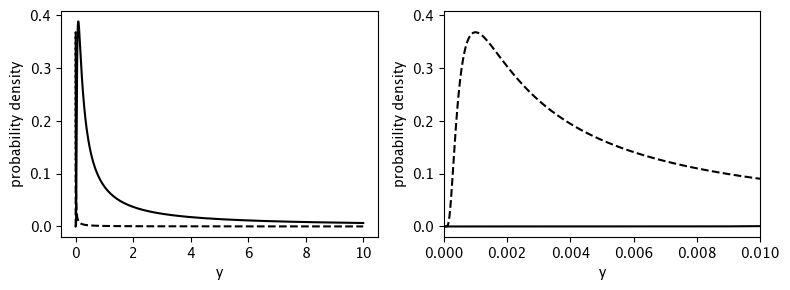

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

"""図10.2."""
x = np.logspace(-10, 1, 600)
p1 = stats.invgamma.pdf(x, a=0.001, scale=0.001)
p2 = stats.invgamma.pdf(x, a=0.1, scale=0.1)

_, axes = plt.subplots(1, 2, figsize=(8, 3))
for i, ax in enumerate(axes):
    ax.plot(x, p1, c="k", linestyle="dashed")
    ax.plot(x, p2, c="k")
    plt.setp(
        ax,
        xlabel="y",
        ylabel="probability density",
        xlim=(0, 0.01) if i == 1 else None,
    )
plt.tight_layout()
plt.show()

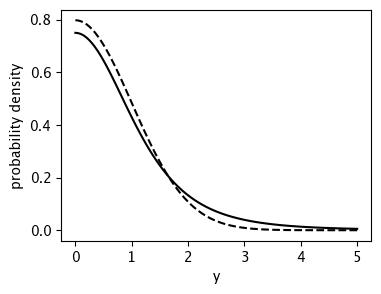

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

"""図10.3."""
x = np.linspace(0, 5, 101)
p1 = 2 * stats.t.pdf(x, df=4)
p2 = 2 * stats.norm.pdf(x)

plt.figure(figsize=(4, 3))
ax = plt.axes()
ax.plot(x, p1, c="k")
ax.plot(x, p2, c="k", linestyle="dashed")
plt.setp(ax, xlabel="y", ylabel="probability density")
plt.show()

17:51:43 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap09/model/model8-4b.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap09/model/model8-4b
17:51:52 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap09/model/model8-4b
17:51:52 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model8-4d.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model8-4d
17:51:57 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model8-4d
17:51:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:51:58 - cmdstanpy - INFO - CmdStan done processing.
17:51:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 30 divergent transitions (3.0%)
	Chain 2 had 24 divergent transitions (2.4%)
	Chain 3 had 4 divergent transitions (0.4%)
	Chain 4 had 7 divergent transitions (0.7%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


17:51:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:51:58 - cmdstanpy - INFO - CmdStan done processing.
17:51:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 13 divergent transitions (1.3%)
	Chain 2 had 6 divergent transitions (0.6%)
	Chain 3 had 5 divergent transitions (0.5%)
	Chain 4 had 3 divergent transitions (0.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


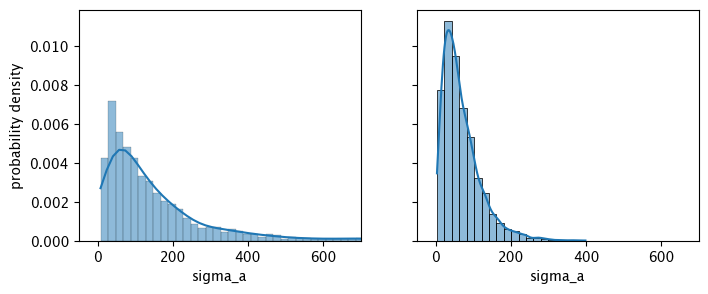

In [26]:
import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
from cmdstanpy import CmdStanModel

"""図10.4"""
salary2_df = pl.read_csv("./chap08/input/data-salary-2.txt")

data = {
    "N": salary2_df.shape[0],
    "K": salary2_df["KID"].max(),
    "X": salary2_df["X"].to_list(),
    "Y": salary2_df["Y"].to_list(),
    "KID": salary2_df["KID"].to_list(),
}

sm1 = CmdStanModel(stan_file="./chap09/model/model8-4b.stan")
sm2 = CmdStanModel(stan_file="./chap10/model/model8-4d.stan")
fit1 = sm1.sample(data=data, seed=1234)
fit2 = sm2.sample(data=data, seed=1234)

_, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
for fit, ax in zip([fit1, fit2], axes, strict=True):
    sns.histplot(fit.s_a, kde=True, binwidth=20, stat="density", ax=ax)
    plt.setp(ax, xlim=(-50, 700), xlabel="sigma_a", ylabel="probability density")
plt.show()

- その他の場合(標準偏差以外に、正の値のみをとるパラメータとその使い方)
  - 指数分布
    1. パラメータ$\beta$に固定値を与える → 収束しやすいが強い仮定であり客観性が減る
    2. $\beta$も何らかの確率分布に従うとして$\mathrm{Exponential}(\beta)$とする
  - ガンマ分布
    1. shapeパラメータ$\alpha$、rateパラメータ$\beta$に固定値を与える
    2. $\alpha$と$\beta$のいづれかか両方が確率分布に従うとして$\mathrm{Gamma}(\alpha,\beta)$を使う
  
  いずれにせよ、分布を実際に描き、意図した事前情報となっているかチェックすることが大切である。
  指数分布と比べると、ガンマ分布の方が様々な形の事前分布を実現できる一方、設定が難しくなり、解釈もしにくいことが多い。
  \
  実例
  将棋のプロ棋士の勝敗データから各棋士の「強さ」と「勝負ムラ」を推定する例を使う。
  球技などと同様、1ゲーム毎に点数をやり取りするレーティングによって強さが数値化される。このレーティングの欠点は以下。
  - 初期値からはじめ、レーティングの数値が落ち着くまでに適正な評価が難しい
  - 評価のタイミングに左右されやすい
  - インフレしやすい
  
  \
  [10.1.5項のウサギとカメ](#1015-ウサギとカメ)のモデルを拡張してこの決定を克服することを目的とする。
  \
  [データファイル10.3](chap10/input/data-shogi-player.txt)

  パラメータ
  - 各棋士の強さ: $\mu[n] \sim \mathrm{Normal}(0, \sigma_\mu)$ とする。棋士が多い(166人)ためすべての棋士と対戦している棋士は存在しない。なので特定の棋士の強さを基準$\mu=0$に固定することができない代わりに、「各棋士の強さ川別は特定の分布に従う」というゆるい制約を入れている
  - 勝負ムラ: $\sigma[n] \sim \mathrm{Gamma}(10, 10)$ (平均1・標準偏差0.32)のガンマ分布に従うという弱情報事前分布を設定。これでパフォーマンスのスケールが勝負ムラ1程度に決まる
  - 1回の勝負で発揮する力(パフォーマンス) $\sim \mathrm{Normal}(\mu[n], \sigma[n])$
  - 各棋士の強さ: $\mu[n]$
  - 各棋士の強さ: $\mu[n]$
  \
  モデル式10-4
  - N: 棋士の人数
  - n: 棋士のインデックス
  - データから$\mu[n], \sigma[n], \sigma_\muとperformance[g, 1], performance[g, 2]$を推定する
  $$
  \begin{align}
  performance[g, 1] &\sim \mathrm{Normal}(\mu [Loser[g]], \sigma[Loser[g]]) &g = 1, \ldots, G \nonumber \\
  performance[g, 2] &\sim \mathrm{Normal}(\mu [Winner[g]], \sigma[Winner[g]]) &g = 1, \ldots, G \nonumber \\
  performance[g, 1] &\lt performance[g, 2] &g = 1, \ldots, G \nonumber \\
  \mu[n] &\sim \mathrm{Normal}(0, \sigma_\mu) &n = 1, \ldots, N \nonumber \\
  \sigma[n] &\sim \mathrm{Gamma}(10, 10) &n = 1, \ldots, N \nonumber
  \end{align}
  $$
  \
  モデル式10-4の実装例
  [model10-4.stan](chap10/model/model10-4.stan)
  プレイヤーが増えたので9, 11行目でパラメータをベクトル化している

In [19]:
import polars as pl
from cmdstanpy import CmdStanModel

"""棋士の強さ"""
shogi_player = pl.read_csv("chap10/input/data-shogi-player.txt")
shogi_player_name = pl.read_csv(
    "chap10/input/data-shogi-player-name.txt",
    separator="\t",
)
N = shogi_player_name["kname"].n_unique()
data = {
    "N": N,  # プレイヤー数
    "G": shogi_player.shape[0],  # 対局数
    "LW": shogi_player.to_numpy(),  # 勝敗データ
}

sm = CmdStanModel(stan_file="chap10/model/model10-4.stan")
fit = sm.sample(data=data, seed=1234)

14:15:18 - cmdstanpy - INFO - compiling stan file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4.stan to exe file /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4
14:15:57 - cmdstanpy - INFO - compiled model executable: /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4
14:15:57 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
14:15:57 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=model10-4.stan --o=/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4.hpp /Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4.stan
Warning in 'model10-4.stan', line 8, column 2: Declaration of arrays by
    placing brackets after a variable name is deprecated and will be removed
    in Stan 2.33.0. Instead use the array keyword before the type. This can
    be changed automatical

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


14:36:44 - cmdstanpy - INFO - CmdStan done processing.
14:36:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable[3] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4.stan', line 20, column 2 to column 23)
	Exception: gamma_lpdf: Random variable[3] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4.stan', line 20, column 2 to column 23)
	Exception: gamma_lpdf: Random variable[3] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4.stan', line 20, column 2 to column 23)
	Exception: gamma_lpdf: Random variable[37] is inf, but must be positive finite! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-4.stan', line 20, column 2 to column 23)
	Exception: normal_lpdf: Scale parameter is 0, 

In [20]:
import numpy as np

mu_median = (
    pl.DataFrame(
        np.median(fit.mu.T, axis=1),
        schema=["median"],
    )
    .with_row_count(name="nid", offset=1)
    .with_columns(pl.col("nid").cast(pl.Int64))
    .join(shogi_player_name, on="nid")
    .sort("median", descending=True)
)
print(mu_median.head(5))  # noqa: T201

s_pf_median = (
    pl.DataFrame(
        np.median(fit.s_pf.T, axis=1),
        schema=["median"],
    )
    .with_row_count(name="nid", offset=1)
    .with_columns(pl.col("nid").cast(pl.Int64))
    .join(shogi_player_name, on="nid")
    .sort("median", descending=True)
)
print(s_pf_median.head(3))  # noqa: T201
print(s_pf_median.tail(3).sort(by="median"))  # noqa: T201

shape: (5, 4)
┌─────┬──────────┬─────┬──────────┐
│ nid ┆ median   ┆ kid ┆ kname    │
│ --- ┆ ---      ┆ --- ┆ ---      │
│ i64 ┆ f64      ┆ i64 ┆ str      │
╞═════╪══════════╪═════╪══════════╡
│ 47  ┆ 1.85224  ┆ 175 ┆ 羽生善治 │
│ 105 ┆ 1.603225 ┆ 235 ┆ 渡辺明   │
│ 134 ┆ 1.33345  ┆ 264 ┆ 豊島将之 │
│ 78  ┆ 1.30165  ┆ 208 ┆ 行方尚史 │
│ 65  ┆ 1.27708  ┆ 195 ┆ 郷田真隆 │
└─────┴──────────┴─────┴──────────┘
shape: (3, 4)
┌─────┬──────────┬─────┬──────────┐
│ nid ┆ median   ┆ kid ┆ kname    │
│ --- ┆ ---      ┆ --- ┆ ---      │
│ i64 ┆ f64      ┆ i64 ┆ str      │
╞═════╪══════════╪═════╪══════════╡
│ 155 ┆ 1.304515 ┆ 285 ┆ 藤森哲也 │
│ 130 ┆ 1.217955 ┆ 260 ┆ 糸谷哲郎 │
│ 116 ┆ 1.217875 ┆ 246 ┆ 横山泰明 │
└─────┴──────────┴─────┴──────────┘
shape: (3, 4)
┌─────┬──────────┬─────┬──────────┐
│ nid ┆ median   ┆ kid ┆ kname    │
│ --- ┆ ---      ┆ --- ┆ ---      │
│ i64 ┆ f64      ┆ i64 ┆ str      │
╞═════╪══════════╪═════╪══════════╡
│ 106 ┆ 0.685188 ┆ 236 ┆ 飯島栄治 │
│ 78  ┆ 0.777017 ┆ 208 ┆ 行方尚史 │
│ 162 ┆ 0.792671 ┆ 292 ┆ 

### 10.2.3 確率など$[0, 1]$の範囲のパラメータ

確率など$[0, 1]$の値のパラメータに設定する弱情報事前分布にはベータ分布やディリクレ分布がある。ここではディリクレ分布を使う例を先に説明する。
[9.4.2項](./chap09.ipynb#942_)の例題では、K面サイコロの各目が出る確率を、simplex型の変数thetaで定義した。thetaには事前分布を設定しなかったので無情報事前分布であった(要素がすべて1である長さ$k$のベクトルを面として、ディリクレ分布$\mathrm{Dirichlet}(\vec{a_0})$が事前分布に設定されたのと同義)。この分布は一様分布に相当する分布。

ここで、出目の出現率が偏ったサイコロを使っているという背景知識を持っているとする。この場合に要素がすべて1.0以下である長さKのベクトルを$\vec{a_0}$として、$\mathrm{Dirichlet}(\vec{a_0})$を事前分布に設定する選択肢もある([6.7節参照](./chap06.ipynb#67-ディリクレ分布))。

コインのように出目が2つの場合にはベータ分布を使う。$\mathrm{Beta}(1, 1)$は一様分布$\mathrm{Uniform}(0, 1)$と完全に等しい。一方で$\mathrm{Beta}(0.5, 0.5)は0や1に近い極端なpが作られやすく歪なコインができやすい分布となる([6.4節参照](./chap06.ipynb#64-ベータ分布))。

### 10.2.4 分散共分散行列

階層モデルを二変量正規分布で拡張する。[8.1.6項](./chap08.ipynb#816-階層モデルの等価な表現)から、モデル式8-4は以下だった。

モデル式 8-4(再掲)

$$
\begin{align}
Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
a[k] &\sim \mathrm{Normal }(a_{全体平均}, \sigma_a) \quad &k = 1, \ldots, K \nonumber \\
b[k] &\sim \mathrm{Normal }(b_{全体平均}, \sigma_b) \quad &k = 1, \ldots, K \nonumber \\
\end{align}
$$

ここで、
- $a[k]$: 新卒の基本年収
- $b[k]$: 年齢に伴う昇給額

はそれぞれ独立の正規分布に従う。ここで新たな背景知識により、a[k]が高い会社はb[k]が低いという相関関係を入れてモデル式を更新する。

モデル式10-5

$$
\begin{align}
Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
\left( \begin{array}{c} a[k] \\ b[k] \end{array} \right) &\sim \mathrm{MultiNormal } \left( \left( \begin{array}{c} a_{全体平均} \\ b_{全体平均} \end{array} \right), \Sigma \right) \quad &k = 1, \ldots, K \nonumber \\
\end{align}
$$

- $\Sigma$: 分散共分散行列であり、無情報事前分布に従うとしてデータから推測する

stanの実装例 [model10-5.stan](chap10/model/model10-5.stan)
- 左辺のベクトル → ab
- 右辺の平均ベクトル → ab0
- 共産共分散$\Sigma$ → cov

このモデル10-5では収束しない。モデルが複雑でパラメータの制限が少ない事に対しデータが不十分と思われる。そこで共産共分散に弱情報事前分布を設定する。かつては逆ウィシャーと分布を使っていたが[10.2.2項](#1022-正の値を持つパラメータ)の逆ガンマ分布と同じ欠点があるかつ、逆ウィシャート分布のパラメータ分布設定が難しい。標準偏差と相関から分散共分散行列を構成する方法と、LKJ分布を使う方法(Stan開発チーム推奨)の2つの方法がある。

- 分散共分散を使う方法
  
  分散共分散は以下で表される。これの式を用いつつ、$\sigma_a$, $\sigma_b$に弱情報事前分布を設定する
  
  $$
  \Sigma = 
  \left(
  \begin{array}{cc}
          {\sigma^2_a} & {\sigma_a\sigma_b\rho} \\
          {\sigma_a \sigma_b \rho} & \sigma^2_b
  \end{array}
  \right)
  $$
  
  また、$a_{全体平均}$と$b_{全体平均}$に対しても弱情報事前分布を設定すると、モデル式は以下となる
  
  \
  モデル式10-6
  
  $$
  \begin{align}
  Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
  \left( 
      \begin{array}{c}
          a[k] \\
          b[k]
      \end{array}
  \right)
  &\sim \mathrm{MultiNormal } \left(
      \left( 
          \begin{array}{c}
              a_{全体平均} \\
              b_{全体平均}
          \end{array}
      \right),
      \left( 
          \begin{array}{cc}
              {\sigma^2_a} & {\sigma_a\sigma_b\rho} \\
          {\sigma_a \sigma_b \rho} & \sigma^2_b
          \end{array}
      \right)
  \right) \quad &k = 1, \ldots, K \nonumber \\
  a_{全体平均} &\sim \mathrm{Normal}(400, 200) \nonumber \\
  b_{全体平均} &\sim \mathrm{Normal}(15, 15) \nonumber \\
  \sigma_a &\sim \mathrm{Student\_t^+}(4, 0, 200) \nonumber \\
  \sigma_b &\sim \mathrm{Student\_t^+}(4, 0, 20) \nonumber \\
  \end{align}
  $$
  
  それぞれの説明変数の弱事前情報分布の意味
  - $a_{全体平均}$: 新卒の基本年収の全体平均は200万円~600万円の範囲である可能性が高い
  - $b_{全体平均}$: 年齢に伴う昇給額の全体平均は0万円~30万円の範囲である可能性が高い
  - $\sigma_a$: 新卒の基本年収の会社差のバラツキは高々200万円だろう
  - $\sigma_b$: 年齢に伴う昇給額の会社差のバラツキは高々20万円だろう
  
  モデル式10-6の実装[model10-6.stan](chap10/model/model10-6.stan)

この方法だと、分散共分散行列のサイズが増えた場合に対応が難しい。例えば回帰係数のすべての係数ではなく、どれかは不明だが一部の係数のみに相関があるだろうと考えたい場合がある。このような場合、LKJ分布を使用する事ができる。

- LKJ相関分布を使う方法
  - 標準偏差に対してはmodel10-6.stanと同様に設定
  - 相関行列に対してはLKJ相関分布で事前分布を設定
  - 行列演算から分散共分散行列を作る。
  
  行列演算が少し難しいが、計算も速く実用性が高い。モデル式にすると以下になる。
  \
  モデル式10-7

  $$
  \begin{align}
  Y[n] &\sim \mathrm{Normal }(a[KID[n]] + b[KID[n]] X[n], \sigma_Y) \quad &n = 1, \ldots, N \nonumber \\
  \left( 
      \begin{array}{c}
          a[k] \\
          b[k]
      \end{array}
  \right)
  &\sim \mathrm{MultiNormal\_Cholesky} \left(
      \left( 
          \begin{array}{c}
              a_{全体平均} \\
              b_{全体平均}
          \end{array}
      \right),
      \Sigma_{\mathrm{chol}}
  \right) \quad &k = 1, \ldots, K \nonumber \\
  \Sigma_{\mathrm{chol}} &= \left(
      \begin{array}{cc}
        \sigma_a & 0 \\
        0 & \sigma_b
      \end{array}
  \right) \Omega_{\mathrm{chol}} \nonumber \\
  a_{全体平均} &\sim \mathrm{Normal}(400, 200) \nonumber \\
  b_{全体平均} &\sim \mathrm{Normal}(15, 15) \nonumber \\
  \sigma_a &\sim \mathrm{Student\_t^+}(4, 0, 200) \nonumber \\
  \sigma_b &\sim \mathrm{Student\_t^+}(4, 0, 20) \nonumber \\
  \Omega_{\mathrm{chol}} &\sim \mathrm{LKJcorr\_Cholesky}(\nu) \nonumber \\
  \end{align}
  $$

  ここで、
  - $\Sigma_{\mathrm{chol}}$: 分散共分散行列のコレスキー因子[<sup>2)</sup>](#fn2)
  - $\Omega_{\mathrm{chol}}$: 相関行列のコレスキー因子
  - $\mathrm{MultiNormal\_Cholesky}$分布: 多変量正規分布(ただし分散共分散行列のかわりにそのコレスキー因子をとる)
  - $\mathrm{LKJcorr\_Cholesky}$分布: 相関行列のコレスキー因子を生成する分布。$\Omega_{\mathrm{chol}}$の事前分布
  - $\nu$: $\mathrm{LKJcorr\_Cholesky}$分布のshapeパラメータで1以上の値を取る。$\nu=1$の場合は相関行列に対し、一様分布に相当する相当する無情報分布となる。大きくなると一部の行と列の組み合わせのみに相関が出るような相関行列が生成される。$\nu=2,4$がよく使われる

  モデル式10-7の実装[model10-7.stan](chap10/model/model10-7.stan)

ここで初出の行列演算関数を下表にまとめる。

表10.2 model10-7.stanで行列演算を行う関数
| 関数                                        | 説明                                                                                                           |
| ------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| diag_pre_multiply(vector v, matrix m)       | diag_matrix(v) * mを計算してmatrix型で返す                                                                     |
| diag_matrix(vector v)                       | vの各要素を対角線上に並べた対角行列をmatrix型で返す                                                            |
| multiply_lower_tri_self_transpose(matrix m) | mの対角成分と下三角成分だけを抜き出した行列を$\bold{L}$とすると、$\bold{L}\bold{L}^T$ を計算してmatrix型で返す |


>[<sup>2)</sup>](#fn2-back) 分散共分散行列をコレスキー分解して得られる行列をさす。コレスキー分解は行列演算の一つで、ここでは推定の高速化のために利用している。



In [25]:
import polars as pl
from cmdstanpy import CmdStanModel

"""二変量正規分布"""

salary2_df = pl.read_csv("./chap08/input/data-salary-2.txt")

data = {
    "N": salary2_df.shape[0],
    "K": salary2_df["KID"].max(),
    "X": salary2_df["X"].to_list(),
    "Y": salary2_df["Y"].to_list(),
    "KID": salary2_df["KID"].to_list(),
}

"""モデル10-5. 収束しない."""
sm10_5 = CmdStanModel(stan_file="./chap10/model/model10-5.stan")
fit10_5 = sm10_5.sample(data=data, seed=1234)
print(fit10_5.summary())  # noqa: T201


sm10_6 = CmdStanModel(stan_file="./chap10/model/model10-6.stan")
fit10_6 = sm10_6.sample(data=data, seed=1234)
print(fit10_6.summary())  # noqa: T201

sm10_7 = CmdStanModel(stan_file="./chap10/model/model10-7.stan")
data["Nu"] = 2
fit10_7 = sm10_7.sample(data=data, seed=1234)
print(fit10_7.summary())  # noqa: T201

17:29:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:29:34 - cmdstanpy - INFO - CmdStan done processing.
17:29:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance matrix[2,1] = nan (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-5.stan', line 26, column 2 to column 30)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-5.stan', line 26, column 2 to column 30)
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is nan. (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-5.stan', line 26, column 2 to column 30)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = nan, but Covariance 

17:29:35 - cmdstanpy - INFO - CmdStan start processing


                  Mean          MCSE        StdDev            5%  \
lp__     -1.760980e+02  2.229890e+00  4.127840e+00 -1.838470e+02   
ab[1,1]   3.856980e+02  4.489060e+00  1.307440e+01  3.693630e+02   
ab[1,2]   7.629180e+00  2.719300e-01  8.238250e-01  6.072980e+00   
ab[2,1]   3.264030e+02  2.652050e+00  1.440020e+01  3.062070e+02   
ab[2,2]   1.999000e+01  1.242190e-01  1.058090e+00  1.811660e+01   
ab[3,1]   3.177370e+02  2.823730e+00  2.722700e+01  2.702040e+02   
ab[3,2]   1.229960e+01  1.373230e-01  1.327110e+00  1.014660e+01   
ab[4,1]   7.402060e+02  6.284720e+01  1.613180e+02  5.262230e+02   
ab[4,2]  -8.373250e-01  2.270020e+00  6.326690e+00 -1.212250e+01   
ab0[1]   -5.424170e+05  1.543431e+06  2.434643e+06 -3.966680e+06   
ab0[2]   -1.434650e+05  1.183830e+05  1.782620e+05 -4.833490e+05   
cov[1,1]  2.130465e+18  2.598645e+18  3.682565e+18  9.718380e+10   
cov[1,2]  3.906775e+15  5.103176e+15  7.233534e+15 -9.837860e+14   
cov[2,1]  3.906775e+15  5.103176e+15  7.233534e+

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:29:36 - cmdstanpy - INFO - CmdStan done processing.
17:29:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-6.stan', line 35, column 2 to column 30)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-6.stan', line 35, column 2 to column 30)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -inf, but Covariance matrix[2,1] = -inf (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-6.stan', line 35, column 2 to column 30)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional va


                 Mean        MCSE       StdDev          5%         50%  \
lp__       -172.83500    0.133194      3.40282  -179.00100  -172.50900   
ab[1,1]     382.20900    0.649800     16.45000   354.42300   382.89800   
ab[1,2]       7.82960    0.038080      1.01975     6.16589     7.79667   
ab[2,1]     335.80900    0.419589     17.58170   306.93600   336.13300   
ab[2,2]      19.30400    0.032055      1.31824    17.16280    19.29070   
ab[3,1]     332.77100    0.892215     32.83000   274.35600   335.38300   
ab[3,2]      11.56740    0.042996      1.61158     9.06313    11.47100   
ab[4,1]     430.14400    3.498750    102.81900   318.98400   397.83800   
ab[4,2]      11.80540    0.139379      4.16538     3.28837    13.02220   
ab0[1]      368.81800    1.325930     53.03920   296.33700   363.38400   
ab0[2]       12.81230    0.112823      4.41022     5.61868    12.85330   
s_a          85.60816    2.513510     71.59406    13.23340    65.11730   
s_b           8.59465    0.141850    

17:29:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:29:37 - cmdstanpy - INFO - CmdStan done processing.
17:29:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: model10_7_model_namespace::log_prob: cov_chol[2] is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-7.stan', line 21, column 2 to column 34)
	Exception: model10_7_model_namespace::log_prob: cov_chol[2] is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-7.stan', line 21, column 2 to column 34)
	Exception: model10_7_model_namespace::log_prob: cov_chol[2] is 0, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-7.stan', line 21, column 2 to column 34)
	Exception: model10_7_model_namespace::log_prob: cov_chol[2] is nan, but must be positive! (in '/Users/sean/Documents/myscript/python-bayes/src/python_bayes/chap10/model/model10-7.stan', line 21, column 2 to column 34)
	Exception


                        Mean        MCSE        StdDev           5%  \
lp__             -172.422000    0.178135  3.280390e+00  -178.197000   
ab[1,1]           381.592000    1.142680  1.597490e+01   353.298000   
ab[1,2]             7.870420    0.088962  1.019370e+00     6.276470   
ab[2,1]           336.116000    0.478603  1.771380e+01   307.222000   
ab[2,2]            19.301100    0.034520  1.313840e+00    17.221100   
ab[3,1]           329.500000    0.883503  3.276410e+01   273.174000   
ab[3,2]            11.695900    0.057440  1.643940e+00     9.214670   
ab[4,1]           440.654000    4.900080  1.119980e+02   319.698000   
ab[4,2]            11.459300    0.225555  4.568690e+00     2.068310   
ab0[1]            373.549000    1.616880  5.768800e+01   299.913000   
ab0[2]             12.703600    0.099787  4.209260e+00     6.104710   
corr_chol[1,1]      1.000000         NaN  6.000000e-16     1.000000   
corr_chol[1,2]      0.000000         NaN  0.000000e+00     0.000000   
corr_

## 10.3 再パラメータ化

モデル式に含まれるパラメータを工夫して変数変換する事によって、サンプリングを効率的にする方法を再パラメータ化という。[5.1.6項](./chap05.ipynb#516-データのスケーリング)で使ったデータのスケーリングもこの一種。ここでは「Nealの漏斗」と呼ばれる極端な例からはじめ、その後階層モデルの例を説明する。

### 10.3.1 Nealの漏斗

この問題では、データはなく事前分布がそのまま事後分布となる。以下で示すモデル式の$a$と$r[n]$を推定する。

モデル式10-8

$$
\begin{align}
a &\sim \mathrm{Normal}(0, 3) \nonumber \\
r[n] &\sim \mathrm{Normal}(0, \exp(a/2)) \quad n = 1, \ldots, 1000 \nonumber \\
\end{align}
$$

このモデル式の対数事後分布は漏斗のような形状になる。2次元に落としてその形を見てみる。例えば横軸に$r[1]$・縦軸にaをとって、対数周辺事後分布($\log{p}(r[1], a)$)の等高線を描くと図10.5の等高線になる。色が明るい部分は対数事後分布の値が大きい箇所であり、$r[1]$が0付近で$a$が0以下の漏斗の先の方である。

Stanの実装例[model10-8a.stan](chap10/model/model10-8a.stan)

データがない場合はdataブロックは不要。この推定結果のMCMCサンプルと等高線を重ねたのが図10.5(左)。本来は対数事後分布の大きいところは比例してサンプリング数を大きくするべきだが、対数事後分布の大きい漏斗の先端付近からほとんどサンプリングできていない。対数事後分布が極端に歪な形なので、まんべんなくスムーズにパラメータを探索できていないからだ。この問題の場合はrの分布の形状(スケール)がaに強く依存していることが原因。

ここで再パラメータ化を実行する。具体的には以下となる。
- raw(生の)パラメータがスケールを固定した分布に従うとする → $\mathrm{Normal}(0, 1)$や$\mathrm{Uniform}(0, 1)$を使うことが多い
- rawパラメータにスケールを掛けることで元のパラメータを表現する

これを踏まえてStanの実装例は、[model10-8b.stan](chap10/model/model10-8b.stan)となる

Normal(0, 1)に従い互いに独立なrawパラメータa_rawとr_rawを用意して、transformed parameterブロック内で、それらからそれぞれaとrを作ってサンプリングする。このように再パラメータ化してスケールを分離すると、a_rawとr_rawの空間では漏斗の形が解消されているので、サンプリングの効率が劇的に改善する。推定結果のMCMCサンプルを図10.5(左)と同じ空間で描くと図10.5(右)となる。

21:42:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

21:42:24 - cmdstanpy - INFO - CmdStan done processing.


21:42:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

21:42:28 - cmdstanpy - INFO - CmdStan done processing.


/var/folders/f5/_tj1zvq95fx0wllynn0tpq800000gn/T/ipykernel_3381/2047754478.py:14: RuntimeWarning: divide by zero encountered in log
  lp = np.log(stats.norm.pdf(y, loc=0, scale=3)) + np.log(


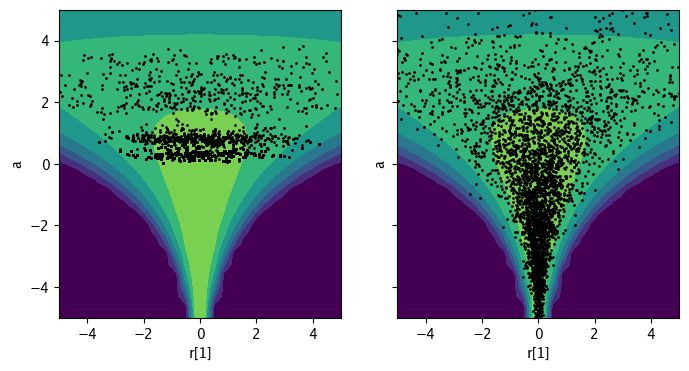

In [33]:
import numpy as np
from cmdstanpy import CmdStanModel
from scipy import stats

"""図10.5"""
sm_a = CmdStanModel(stan_file="./chap10/model/model10-8a.stan")
fit_a = sm_a.sample(chains=1, iter_warmup=2000, iter_sampling=4000, seed=123)
sm_b = CmdStanModel(stan_file="./chap10/model/model10-8b.stan")
fit_b = sm_b.sample(chains=1, iter_warmup=2000, iter_sampling=4000, seed=123)

xx, yy = np.mgrid[-5:5:30j, -5:5:30j]
points = np.c_[xx.ravel(), yy.ravel()]
x, y = points[:, 0], points[:, 1]
lp = np.log(stats.norm.pdf(y, loc=0, scale=3)) + np.log(
    stats.norm.pdf(x, loc=0, scale=np.exp(y / 2)),
)
lp[lp < -15] = -15

_, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for fit, ax in zip([fit_a, fit_b], axes, strict=True):
    cs = ax.contourf(xx, yy, lp.reshape(xx.shape), vmin=-15, vmax=0)
    xlim = (-5, 5)
    ylim = (-5, 5)
    ax.scatter(fit.r[:, 0], fit.a, s=1, c="k")
    plt.setp(ax, xlabel="r[1]", ylabel="a", xlim=xlim, ylim=ylim)
plt.show()

### 10.3.2 階層モデル

階層モデルにおいても再パラメータ化が有用な場合がある。[model8-4b.stan](chap09/model/model8-4b.stan)を再パラメータ化してみる。

実装例[model8-4c.stan](chap10/model/model8-4c.stan)

model8-4b.stanからの変更点
- parameterブロックのa, bをrawパラメータa_raw, b_rawへ変更
- transformed parametersブロックにて、rawパラメータa_raw, b_rawにそれぞれスケールs_a, s_bを掛けて、平均a0, b0を加えてa, bを作る
- raw_パラメータa_raw, b_rawは$\mathrm{Normal}(0, 1)$に従うことをmodelブロックに記述

再パラメータ化により階層モデルの収束が改善する事があるが、計算が遅くなる場合もある。再パラメータ化を行うケースとして、
- データが少ない場合に再パラメータ化を試す
- ある階層・あるグループだけ部分的にデータが少ない場合はその部分だけの再パラメータ化を検討する

## 10.4 その他の場合

[10.1節](#101-パラメータの識別可能性)~[10.3節](#103-再パラメータ化)の方法では改善しない場合。例えば、
- 微分が不連続な関数を使ったモデル
  モデルの中に、パラメータを引数としたstep関数・abs関数・fmax関数・ceil関数[<sup>5)</sup>](#fn5)などの微分が不連続な関数や、パラメータの値に応じた条件分があると、偏微分の計算が効率的にできなくなり、推定計算が遅くなる上に収束しにくい場合がある。

  そのような場合には、モデル式の変形で微分が不連続な関数を消去できないか検討する、あるいは微分が不連続な関数を含まないモデル式を代わりに考えるとよいだろう。
- 局所最適解が多いモデル
  問題によってはパラメータに深い局所最値が多数存在する場合がある。そのような場合には、今までの手法ではうまく行かない可能性がある。レプリカ交換法(replica exchange method, parallel temperingとも呼ぶ)などの発展的方法を使うと解決する場合がある。R側で工夫するとそれらの方法を実装することもできる。[<sup>6)</sup>](#fn6)

## 補足と文献案内

パラメータの識別可能性の例は、Stanのマニュアルの「Problematic Posteriors」の章に複数掲載されている。

弱情報事前分布についてはStanのWikiページ「Prior Choice Recommendations[<sup>7)</sup>](#fn7)」を参考にした。有益な情報が多く必読である。また、WinBUGSに付属している例題をStanで実装し直したものが公式のGitHubのリポジトリにある[<sup>8)</sup>](#fn8)。WinBUGSのドキュメントを読んで問題の背景を理解したあとで、弱事前情報分布を使った Stanコードを読むと参考になるだろう(例えばvol1のpumps).LKJ相関分布について興味ある読者は、Stanのマニュアルの「Multivariate Priors for Hierarchical Models」の節や「Correlation Matrix Distributions」の章を参照してほしい。

再パラメータ化については Stanのマニュアルが詳しい．「Reparameterization & Change of Variables」の章が用意されている他。例えば「Optimizing Stan Code」の章には多変量正規分布に従う変数を再パラメータ化する場合が載っている。

レプリカ交換法について興味ある読者は[13](伊庭幸入ら. (2005). 計算統計II. 岩波書店.)を読むとよいだろう。

  >[<sup>5)</sup>](#fn5-back) 詳しく知りたい読者はStanのマニュアルの「Step-like Functions」の節を参照してほしい。
  >
  >[<sup>6)</sup>](#fn6-back) http://statmodeling.hatenablog.com/entry/stan-parallel-tempering
  >
  >[<sup>7)</sup>](#fn7-back) https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations
  >
  >[<sup>8)</sup>](#fn8-back) https://github.com/stan-dev/example-models